In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cmdstanpy
import numpy as np
import cmdstanpy
#cmdstanpy.install_cmdstan
import os
import json
import random
from scipy.special import expit
from tqdm import tqdm
os.cpu_count()

12

$P(X) = \frac{1}{Z}\exp{\sum_i{x_i(\gamma w_i + \beta_i z)} + \sum_{i,j}{x_i x_j (\theta_j w_i +\theta_i w_j)}}$

$P(x_i = 1 | x_{-i}) = logit^{-1}(\gamma w_i + \beta_i z + \sum_{j}{x_j \theta( w_i + w_j)})$

In [4]:
op_sample = pd.read_csv("data/instacart/order_product_sample.csv")
o_sample = pd.read_csv("data/instacart/orders_sample.csv")
p_sample = pd.read_csv("data/instacart/products_sample.csv")
op_sample = op_sample.merge(p_sample[["product_id", "aisle_id"]])

In [5]:
test_orders = o_sample.groupby("user_id",as_index=False).agg({"order_id":"last"})["order_id"].unique().tolist()
with open('data/instacart/test_orders.json', 'w', encoding='utf-8') as f:
    json.dump(test_orders, f)
# Creamos el diccionario para los nodos (productos)
df_products = p_sample[["aisle_id", "department"]].copy()
#df_products["aisle"] = df_products.aisle.apply(lambda x: "aisle:"+x)
df_products["department"] = df_products.department.apply(lambda x: "department:"+x)
cat_cols = ["department"]
for col in cat_cols:
    ddummies = pd.get_dummies(df_products[col], dtype=int, drop_first=True)
    df_products = pd.concat([df_products, ddummies], axis=1)
    df_products.drop(columns=col, inplace=True)
products = df_products.drop_duplicates().set_index("aisle_id").to_dict(orient="index")

# Creamos los diccionarios para los enlaces (compras)
orders_attr = o_sample.copy().drop(columns=["order_number", "lunes", "am"]).set_index("order_id").to_dict(orient="index")
orders_nodes = op_sample.copy().groupby("order_id")["aisle_id"].apply(set).apply(list).to_dict()

with open('data/instacart/products.json', 'w', encoding='utf-8') as f:
    json.dump(products, f)

with open('data/instacart/orders_attr.json', 'w', encoding='utf-8') as f:
    json.dump(orders_attr, f)

with open('data/instacart/orders_nodes.json', 'w', encoding='utf-8') as f:
    json.dump(orders_nodes, f)

for order in test_orders:
    del orders_attr[order]
    del orders_nodes[order]

In [6]:
len(orders_attr)

98

In [7]:
y = []
z = []

n_attr = len(list(products[next(iter(products))].values()))

for order in orders_attr.keys():
    P_ = orders_nodes[order]
    y_ = []
    z.append(list(orders_attr[order].values()))
    for prod in products.keys():

        if prod in P_: 
            y_.append(1)
            
        else: 
            y_.append(0)

        
    y.append(y_)

N = len(products)
M = len(y)
W = len(products[1])
w = [list(i.values()) for i in products.values()]
Z = len(z[0])

cmdstanpy.write_stan_json("stan_models/instacart_data.json", {"N":N, "M":M, "W":W, "Z":Z, "y":y, "w":w, "z":z})

In [6]:
stan_model = cmdstanpy.CmdStanModel(stan_file=os.path.join("stan_models",'rmf-pseudo1.stan'), force_compile=True
                                    )

fit = stan_model.sample(
    data="stan_models/instacart_data.json",
    chains=4,
    iter_sampling=1000,
    iter_warmup=500,
    seed=12345, show_console=True
)

23:44:07 - cmdstanpy - INFO - compiling stan file C:\Users\dimot\Documents\Universidad\tesis\tesis\testing_experiments\stan_models\rmf-pseudo1.stan to exe file C:\Users\dimot\Documents\Universidad\tesis\tesis\testing_experiments\stan_models\rmf-pseudo1.exe
23:44:23 - cmdstanpy - INFO - compiled model executable: C:\Users\dimot\Documents\Universidad\tesis\tesis\testing_experiments\stan_models\rmf-pseudo1.exe
23:44:24 - cmdstanpy - INFO - Chain [1] start processing
23:44:24 - cmdstanpy - INFO - Chain [2] start processing
23:44:24 - cmdstanpy - INFO - Chain [3] start processing
23:44:24 - cmdstanpy - INFO - Chain [4] start processing


Chain [4] method = sample (Default)
Chain [1] method = sample (Default)
Chain [4] sample
Chain [4] num_samples = 1000 (Default)
Chain [4] num_warmup = 500
Chain [4] save_warmup = false (Default)
Chain [4] thin = 1 (Default)
Chain [4] adapt
Chain [4] engaged = true (Default)
Chain [4] gamma = 0.05 (Default)
Chain [4] delta = 0.8 (Default)
Chain [4] kappa = 0.75 (Default)
Chain [4] t0 = 10 (Default)
Chain [4] init_buffer = 75 (Default)
Chain [4] term_buffer = 50 (Default)
Chain [4] window = 25 (Default)
Chain [4] save_metric = false (Default)
Chain [4] algorithm = hmc (Default)
Chain [4] hmc
Chain [4] engine = nuts (Default)
Chain [4] nuts
Chain [4] max_depth = 10 (Default)
Chain [4] metric = diag_e (Default)
Chain [4] metric_file =  (Default)
Chain [4] stepsize = 1 (Default)
Chain [4] stepsize_jitter = 0 (Default)
Chain [4] num_chains = 1 (Default)
Chain [4] id = 4
Chain [4] data
Chain [4] file = stan_models/instacart_data.json
Chain [4] init = 2 (Default)
Chain [4] random
Chain [4] see

01:04:37 - cmdstanpy - INFO - Chain [3] done processing


Chain [3] 
Chain [3] Elapsed Time: 2941.53 seconds (Warm-up)
Chain [3] 1871.24 seconds (Sampling)
Chain [3] 4812.77 seconds (Total)
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [2] Iteration: 1400 / 1500 [ 93%]  (Sampling)
Ch

01:06:06 - cmdstanpy - INFO - Chain [1] done processing


Chain [1] 
Chain [1] Elapsed Time: 3050.78 seconds (Warm-up)
Chain [1] 1850.76 seconds (Sampling)
Chain [1] 4901.55 seconds (Total)
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [4] Iteration: 1500 / 1500 [100%]  (Sampling)


01:06:12 - cmdstanpy - INFO - Chain [4] done processing


Chain [4] 
Chain [4] Elapsed Time: 3053.68 seconds (Warm-up)
Chain [4] 1854.07 seconds (Sampling)
Chain [4] 4907.76 seconds (Total)
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [2] Iteration: 1500 / 1500 [100%]  (Sampling)


01:07:00 - cmdstanpy - INFO - Chain [2] done processing


Chain [2] 
Chain [2] Elapsed Time: 3144.62 seconds (Warm-up)
Chain [2] 1811.01 seconds (Sampling)
Chain [2] 4955.63 seconds (Total)
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 

In [7]:
fit.save_csvfiles("stan_models/fitted_logit")

In [9]:
print(fit.diagnose())

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete, no problems detected.



#### Análisis de datos (mover al otro archivo)

$P(X) = \frac{1}{Z}\exp{\sum_i{x_i(\gamma w_i + \beta_i z)} + \sum_{i,j}{x_i x_j (\theta_j w_i +\theta_i w_j)}}$

$P(x_i = 1 | x_{-i}) = logit^{-1}(\gamma w_i + \beta_i z + \sum_{j}{x_j \theta( w_i + w_j)})$

In [8]:
rmf_pseudo1 = cmdstanpy.from_csv("stan_models/fitted_logit")

In [9]:
test_order = o_sample[o_sample["order_id"]==test_orders[0]]
test_user = test_order.user_id.values[0]
z_j1 = test_order[["user_id", "martes", "miercoles", "jueves", "viernes", "sabado", "domingo", "pm"]].values[0]

In [ ]:
products_attr = {key:list(products[key].values()) for key in products.keys()}
gammas = rmf_pseudo1.gamma
betas = rmf_pseudo1.beta
thetas = rmf_pseudo1.theta


def gibbs_sampler(n, gammas, betas, thetas):
    group_samples = []
    group = []
    probs_samples = []
    probs = [0] * N
    # Definimos grupo inicial
    for i in range(N):
        group.append(0) if random.random() < 0.5 else group.append(1)

        par_sample = random.randint(0, 3999)

        gamma = gammas[par_sample]
        beta = betas[par_sample]
        theta = thetas[par_sample]
    # Sampleamos
    for i in tqdm(range(n)):
        # Obtenemos el orden aleatorio del sampler
        products_index = random.sample(list(products.keys()), len(products.keys()))

        # Obtenemos los parámetros
        for p in products_index:
            unary = np.dot(products_attr[p], gamma) + np.dot(beta[p-1], z_j1)
            binary = np.dot(group, (np.dot(w + np.tile(w[p-1], (N,1)), theta))) - group[p-1] * 2 * np.dot(w[p-1], theta)
            u = unary + binary
            prob = expit(u)
            probs[p-1] = prob
            if random.random() < prob:
                group[p-1] = 1
            else:
                group[p-1] = 0
                
        if (i+1 > 1000) & ((i+1)%20 == 0):
            group_samples.append(group.copy())
            probs_samples.append(probs.copy())
            
    return (group_samples, probs_samples)



In [ ]:
import multiprocessing as mp

products_attr = {key:list(products[key].values()) for key in products.keys()}
gammas = rmf_pseudo1.gamma
betas = rmf_pseudo1.beta
thetas = rmf_pseudo1.theta


def run_chain(args):
    n, betas, gammas, thetas = args
    return gibbs_sampler(n=n, betas=betas, gammas=gammas, thetas=thetas)

if __name__ == "__main__":
    n = 100_000
    n_chains = 5

    # supongo que ya tienes betas, gammas y thetas definidos
    # betas = ...
    # gammas = ...
    # thetas = ...

    # preparo los argumentos (todos iguales en tu caso)
    args_list = [(n, betas, gammas, thetas) for _ in range(n_chains)]

    # lanzo en paralelo (5 procesos)
    with mp.Pool(processes=n_chains) as pool:
        chains = pool.map(run_chain, args_list)

    # ahora tienes una lista con las 5 ejecuciones
    for i, samples in enumerate(chains):
        print(f"Cadena {i}: {len(samples)} muestras")


<Axes: ylabel='Count'>

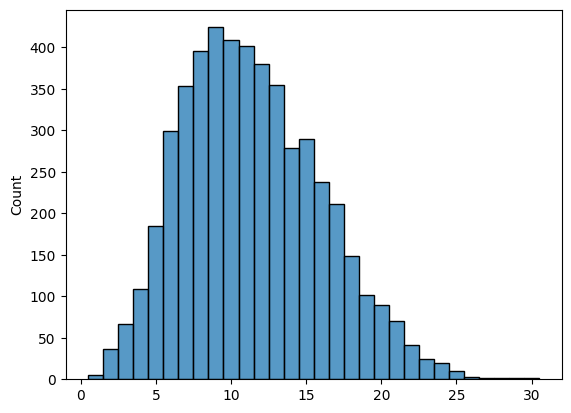

In [200]:
size = []
for samp in group_samples:
    size.append(sum(samp))
sns.histplot(size, discrete=True)

In [ ]:
import networkx as nx
edges = []
for d in orders_nodes.keys():
    nodes = orders_nodes[d]
    for node1 in nodes:
        for node2 in nodes:
            if node1 != node2:
                edges.append((node1, node2))
G = nx.from_edgelist(edges)

layout = nx.spring_layout(k=5, iterations=2000, G=G)
ps = np.array([0]*N)
for g in group_samples:
    ps = ps + np.array(g)
ps = ps / len(group_samples)
p_items = {i+1:{"p":ps[i]} for i in range(len(ps))}
nx.set_node_attributes(G, p_items)

Probabilidad míninma: 0.0006060606060606061 & Probabilidad máxima: 0.935959595959596


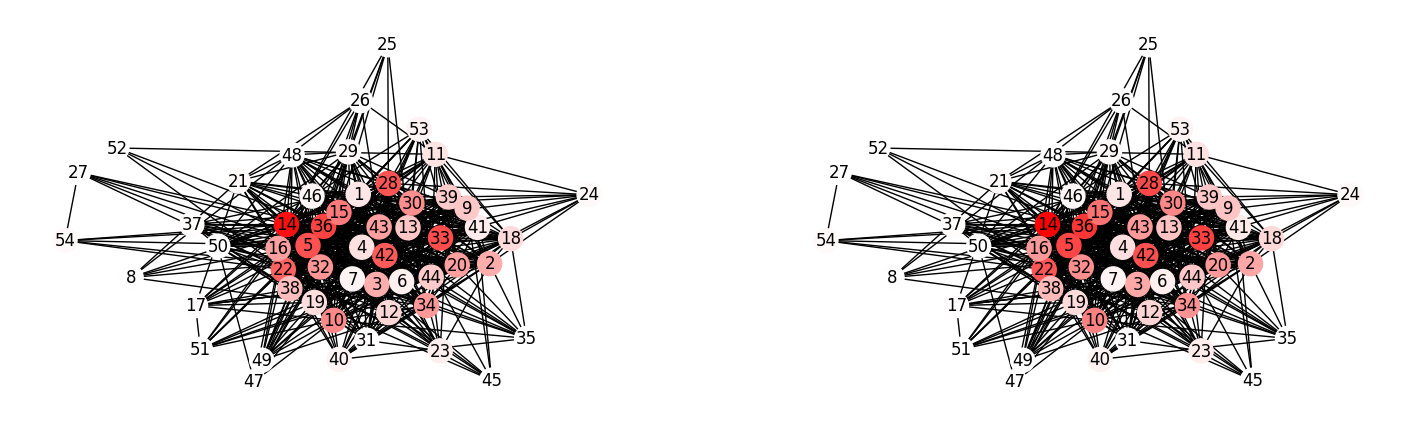

In [233]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.cm import ScalarMappable

# Crear colormap blanco → rojo
white_red = LinearSegmentedColormap.from_list("white_red", ["white", "red"])
red_white = LinearSegmentedColormap.from_list("red_white", ["red", "white"])
p_values = [G.nodes[n]["p"] for n in G.nodes]
pos = nx.spring_layout(G, k=2, iterations=100, seed=42)
plt.figure(figsize=(18,18))
plt.subplot(321)
nx.draw(
    G,
    node_color=p_values,
    cmap=white_red,     # azul-blanco-rojo
    vmin=0, vmax=1,      # escala entre 0 y 1
    with_labels=True,
    pos=pos
)
plt.subplot(322)
nx.draw(
    G,
    node_color=p_values,
    cmap=white_red,     # azul-blanco-rojo
    vmin=min(p_values), vmax=max(p_values),      # escala entre 0 y 1
    with_labels=True,
    pos=pos
)

print("Probabilidad míninma: " + str(min(p_values)) + " & Probabilidad máxima: " + str(max(p_values)))
plt.show()

In [198]:
op_sample[op_sample.order_id.isin(test_order.order_id.values)]

,order_id,product_id,aisle_id
71,99,82,13
72,99,126,5
73,99,65,36
74,99,21,18
75,99,69,2
76,99,129,1


In [16]:
op_sample[op_sample["order_id"].isin(o_sample[o_sample["user_id"] == 1].order_id.unique())].groupby(["aisle_id"]).agg({"order_id":"size"})

,order_id
aisle_id,
1,20
2,14
3,33
4,14
5,67
6,11
7,13
8,1
9,7


In [236]:
# Requeridos
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.cluster import hierarchy
from sklearn.manifold import MDS, TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Convertir a array (N x n) de 0/1
X = np.array(group_samples, dtype=int)   # shape (N, n)
N, n = X.shape


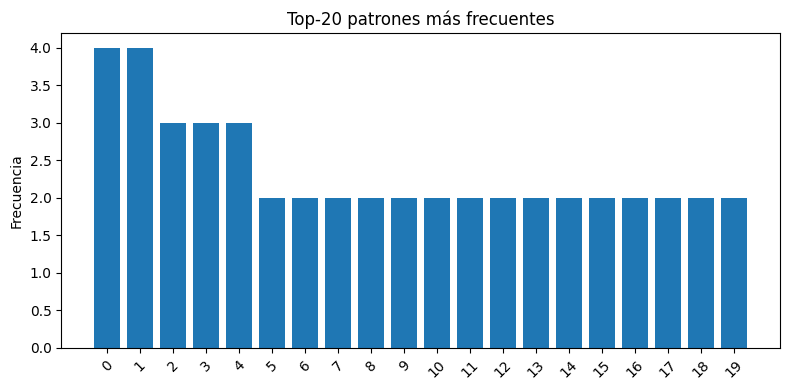

In [237]:
# contar patrones (tuplas para ser hashables)
counts = Counter(map(tuple, X))
topk = counts.most_common(20)   # cambiar k
patterns = [np.array(p) for p, c in topk]
freqs = [c for p, c in topk]

# plot top-k
plt.figure(figsize=(8,4))
plt.bar(range(len(freqs)), freqs)
plt.xticks(range(len(freqs)), [str(p) for p in range(len(freqs))], rotation=45)
plt.ylabel('Frecuencia')
plt.title('Top-{} patrones más frecuentes'.format(len(freqs)))
plt.tight_layout()
plt.show()


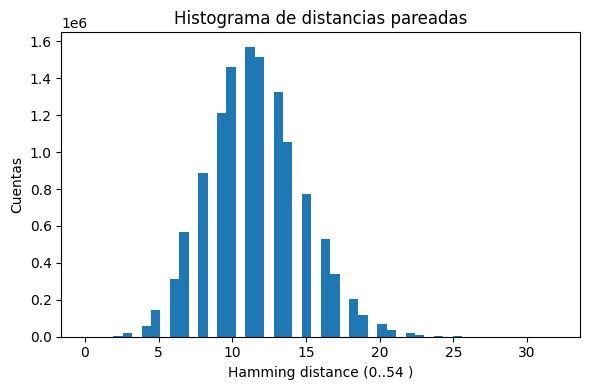

In [238]:
# distancia de Hamming (proporción) con pdist
# pdist(metric='hamming') devuelve proporción de coordenadas diferentes
pairwise_hamming = pdist(X, metric='hamming') * n   # opcional: multiplicar por n para distancia en enteros
# plot histograma
plt.figure(figsize=(6,4))
plt.hist(pairwise_hamming, bins=50)
plt.xlabel('Hamming distance (0..{} )'.format(n))
plt.ylabel('Cuentas')
plt.title('Histograma de distancias pareadas')
plt.tight_layout()
plt.show()


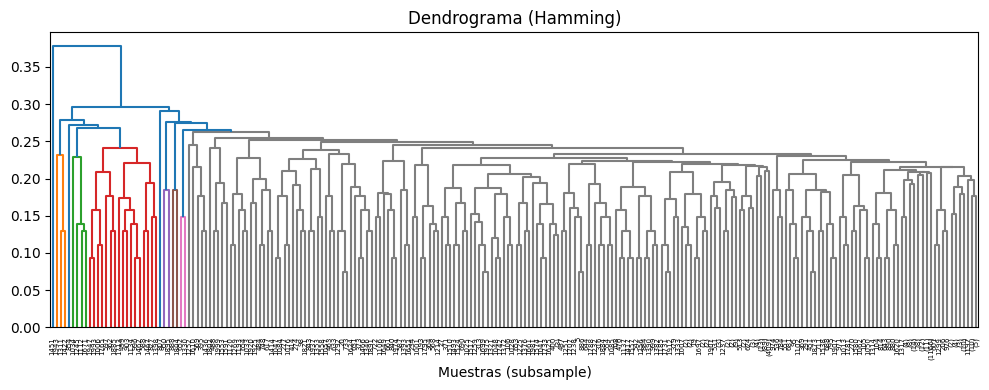

In [240]:
# usar una submuestra si N grande
sub = X_vis  # del bloque anterior
Z = pdist(sub, metric='hamming')
link = hierarchy.linkage(Z, method='average')   # o 'single' / 'complete'
plt.figure(figsize=(10,4))
dn = hierarchy.dendrogram(link, truncate_mode='level', p=20)  # truncar para mostrar resumen
plt.title('Dendrograma (Hamming)')
plt.xlabel('Muestras (subsample)')
plt.tight_layout()
plt.show()


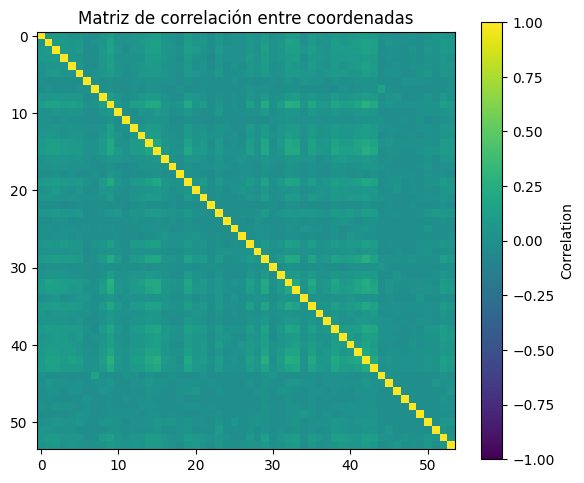

In [244]:
corr = np.corrcoef(X.T)   # phi coefficient en datos binarios
plt.figure(figsize=(6,5))
plt.imshow(corr, aspect='equal', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')
plt.title('Matriz de correlación entre coordenadas')
plt.tight_layout()
plt.show()


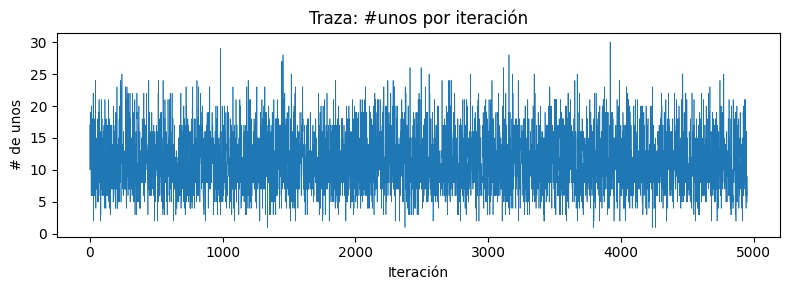

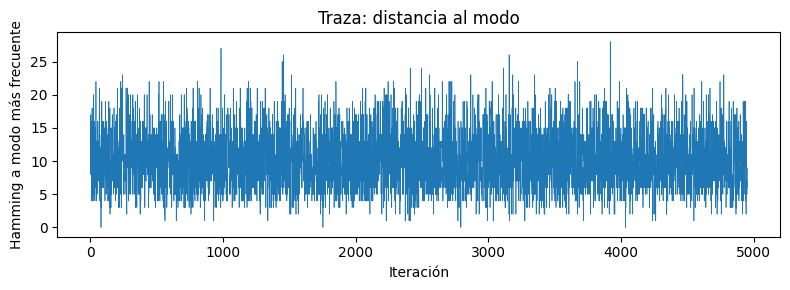

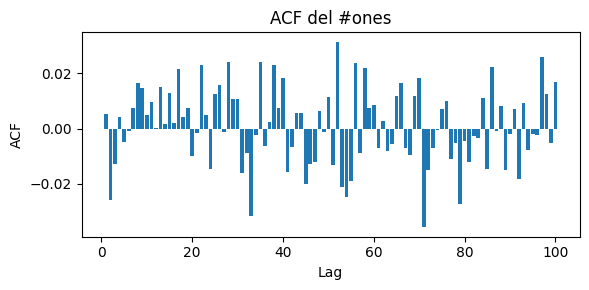

In [245]:
# ejemplo de resumen: número de unos por muestra
ones_count = X.sum(axis=1)

plt.figure(figsize=(8,3))
plt.plot(ones_count, lw=0.5)
plt.ylabel('# de unos')
plt.xlabel('Iteración')
plt.title('Traza: #unos por iteración')
plt.tight_layout()
plt.show()

# distancia Hamming a la moda global (o a la moda más frecuente)
most_common_pattern = np.array(counts.most_common(1)[0][0])
hamming_to_mode = (X != most_common_pattern).sum(axis=1)

plt.figure(figsize=(8,3))
plt.plot(hamming_to_mode, lw=0.5)
plt.ylabel('Hamming a modo más frecuente')
plt.xlabel('Iteración')
plt.title('Traza: distancia al modo')
plt.tight_layout()
plt.show()

# Autocorrelacion simple para el summary (implementación rápida)
def autocorr(x, lag):
    x = np.asarray(x)
    x = x - x.mean()
    return np.corrcoef(x[:-lag], x[lag:])[0,1]

lags = np.arange(1,101)
ac = [autocorr(ones_count, l) for l in lags]
plt.figure(figsize=(6,3))
plt.bar(lags, ac)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title('ACF del #ones')
plt.tight_layout()
plt.show()


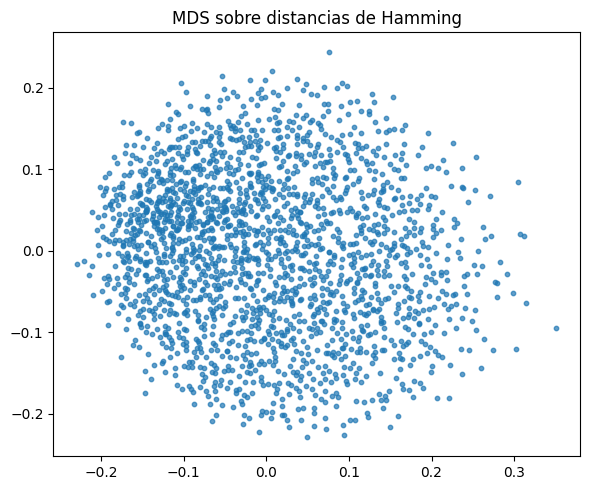

ValueError: The parameter init="pca" cannot be used with metric="precomputed".

In [246]:
# crear matriz de distancia (si N grande, subsamplear)
max_plot = 2000
if N > max_plot:
    idx = np.random.RandomState(0).choice(N, max_plot, replace=False)
    X_vis = X[idx]
else:
    X_vis = X

D = squareform(pdist(X_vis, metric='hamming'))  # proporción
# MDS
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=0)
Z_mds = mds.fit_transform(D)

plt.figure(figsize=(6,5))
plt.scatter(Z_mds[:,0], Z_mds[:,1], s=10, alpha=0.7)
plt.title('MDS sobre distancias de Hamming')
plt.tight_layout()
plt.show()

# t-SNE (usa la matriz de distancia: set metric='precomputed' in sklearn >=1.2, else use perplexity on raw)
tsne = TSNE(n_components=2, metric='precomputed', random_state=0)
Z_tsne = tsne.fit_transform(D)
plt.figure(figsize=(6,5))
plt.scatter(Z_tsne[:,0], Z_tsne[:,1], s=10, alpha=0.7)
plt.title('t-SNE (precomputed Hamming)')
plt.tight_layout()
plt.show()
